In [16]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.signal import chirp
from scipy.special import hyperu, laguerre, genlaguerre, hyp1f1
from scipy.constants import hbar
from scipy.constants import k as kB
from tqdm import tqdm
import dill
from scipy.integrate import quad
import qcontrol as qc

In [17]:
qargs = {
    'optical_fc':           2e9, 
    'optical_df':           0.3e9,
    'mw_fc':                1.3e9, 
    'optical_lifetime':     1/6e-9, 
    'branching_ratio':      0.0005,
    'dark_count_rate':      10e3,
    'coupling_efficiency':  0.01,
    'debye_waller_factor':  0.8,
    'non_radiative_factor': 0.6,
    }
q = qc.ColorCenterQubit(**qargs)
pulses = {
    'pi' : {
        'frequency' : q.mw_fc,
        'width' : 115e-9,
        't_ramp' : 10e-9,
        'amplitude' : 30.0e6
    },
    'pi/2' : {
        'frequency' : q.mw_fc,
        'width' : 62.5e-9,
        't_ramp' : 10e-9,
        'amplitude' : 30.0e6
    },
    'readout_down' : {
        'frequency' : q.f0,
        'width' : 60e-6,
        't_ramp' : 1e-6,
        'amplitude' : 3e8
    },
    'readout_up' : {
        'frequency' : q.f1,
        'width' : 60e-6,
        't_ramp' : 1e-6,
        'amplitude' : 3e8
    },
    'init_up' : {
        'frequency' : q.f0,
        'width' : 120e-6,
        't_ramp' : 1e-6,
        'amplitude' : 3e8
    },
    'init_fast' : {
        'frequency' : q.f1-q.f0+q.mw_fc,
        'width' : 120e-6,
        't_ramp' : 1e-6,
        'amplitude' : 30e6
    }
}


phase_flags = { '_X' : 0, '_Y' : np.pi/2, '_-X' : np.pi, '_-Y' : -np.pi/2}

def process_pulse_train(t, pulse_sequence, plot=False):
    pulse_sigs = {}
    for channel, pulse_dict in pulse_sequence.items():
        pulse_sigs[channel] = np.zeros_like(t, dtype=complex)
        current_time = 0
        pulse_train = pulse_dict['pulse_train']
        for p in pulse_train:
            if isinstance(p, str):
                phase = 0
                for flag, phase_val in phase_flags.items():
                    if flag in p:
                        phase = phase_val
                        p = p.replace(flag, '')
                envelope = qc.tools.__smooth_square_pulse(None, t, current_time, pulses[p]['width'], pulses[p]['t_ramp'], pulses[p]['amplitude'])
                modulation = np.cos(2*np.pi*pulses[p]['frequency']*t+phase)
                pulse_sigs[channel] += envelope*modulation
                if plot:
                    plt.plot(t*1e6, envelope/np.max(envelope), label=f"{channel} Envelope")
                current_time += pulses[p]['width']
            else:
                current_time += p
    if plot:
        for channel, pulse_sig in pulse_sigs.items():
            plt.plot(t*1e6, pulse_sig/np.max(pulse_sig), label=channel)

        plt.legend()
        plt.xlabel('Time (us)')
        plt.ylabel('Pulse Amplitude')
        plt.title('Pulse Sequence')
        
    return pulse_sigs

def get_pulse_train_time(pulse_sequence):
    max_time = 0
    for channel, pulse_dict in pulse_sequence.items():
        current_time = 0
        pulse_train = pulse_dict['pulse_train']
        for p in pulse_train:
            if isinstance(p, str):
                phase = 0
                for flag, phase_val in phase_flags.items():
                    if flag in p:
                        phase = phase_val
                        p = p.replace(flag, '')
                current_time += pulses[p]['width']
            else:
                current_time += p
        max_time = max(max_time, current_time)
    return max_time


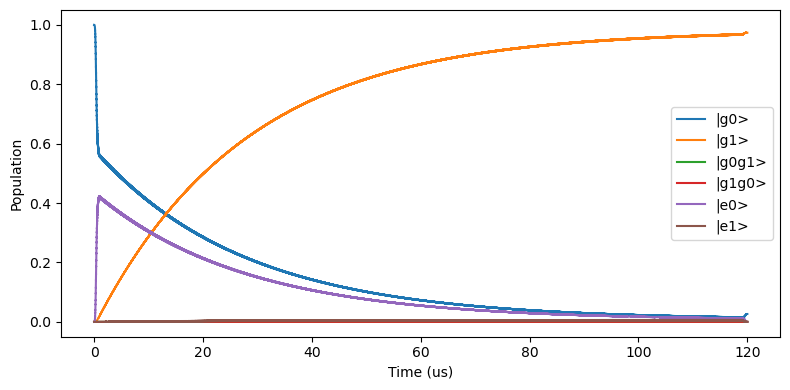

In [18]:
init_sequence = {
    'optical' : {'pulse_train' : ['init_up']}
}
t = np.arange(0, get_pulse_train_time(init_sequence), 1/6.144e9)
init_sigs = process_pulse_train(t, init_sequence, plot=False)

q = qc.ColorCenterQubit(**qargs)
result = q.apply_pulse_sequence(t, init_sigs, plot=True)


Text(0, 0.5, 'PSB Counts')

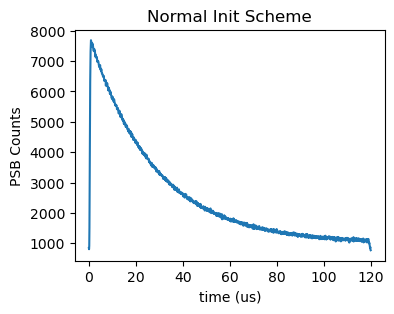

In [19]:
bin_res = 500

dt = t[bin_res-1]-t[0]
reps = 1e6
zpl_counts, psb_counts = q.process_result(result, dt, bin_res, reps, use_dark_counts=True)
counts_t = t[::bin_res]
plt.figure(figsize=(4,3))
plt.plot(counts_t*1e6, psb_counts)
plt.title("Normal Init Scheme")
plt.xlabel('time (us)')
plt.ylabel('PSB Counts')

/home/floresh2/.conda/envs/zm/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/floresh2/.conda/envs/zm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


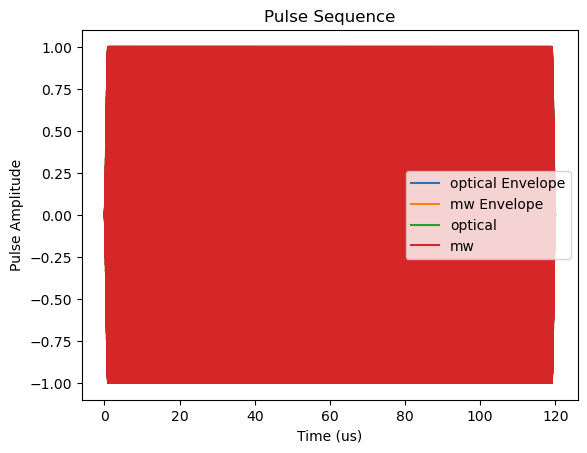

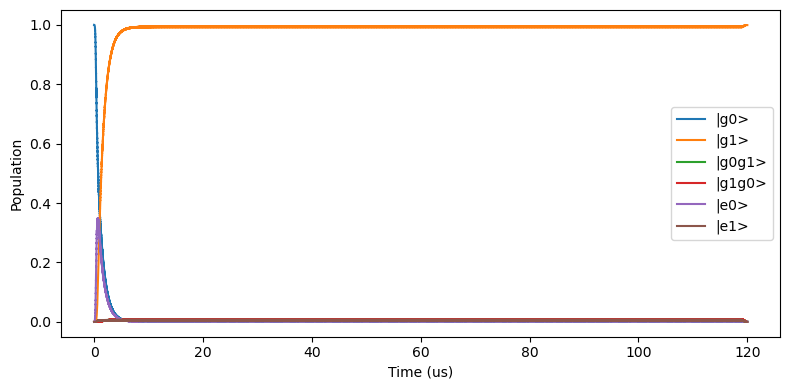

In [20]:
init_sequence = {
    'optical' : {'pulse_train' : ['init_up']},
    'mw' : {'pulse_train' : ['init_fast']}
}
t = np.arange(0, get_pulse_train_time(init_sequence), 1/6.144e9)
init_sigs = process_pulse_train(t, init_sequence, plot=True)


q = qc.ColorCenterQubit(**qargs)
result = q.apply_pulse_sequence(t, init_sigs, plot=True)

Text(0, 0.5, 'PSB Counts')

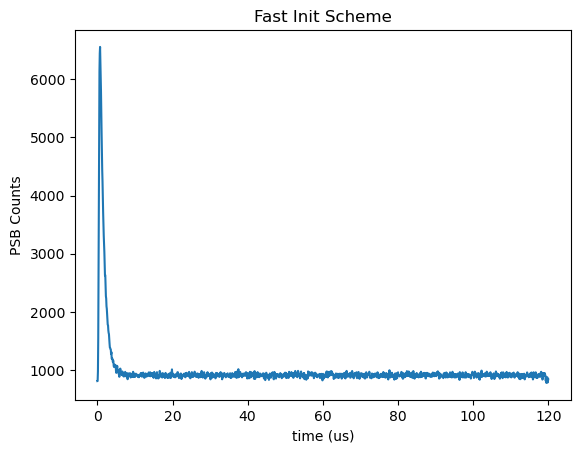

In [21]:
bin_res = 500

dt = t[bin_res-1]-t[0]
reps = 1e6
zpl_counts, psb_counts = q.process_result(result, dt, bin_res, reps, use_dark_counts=True)
counts_t = t[::bin_res]
plt.plot(counts_t*1e6, psb_counts)
plt.title("Fast Init Scheme")
plt.xlabel('time (us)')
plt.ylabel('PSB Counts')